In [4]:
from eo_utils import * 

In [20]:
conn = openeo.connect("https://openeo-dev.eodc.eu/v1.0")
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo-dev.eodc.eu/v1.0' with BearerAuth>

In [220]:
center = [48.179049, 16.396771]
zoom = 10
#this is a comment 
eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[48.179049, 16.396771], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [221]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 15.725555419921877 
east 17.06863403320313 
south 47.995435916095225 
north 48.36172402219373


In [222]:
collection      = 'SENTINEL1_SIGMA0_20M'

spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2020-01-01", "2020-12-31"] 

bands           = ["VV", "VH"] 

data = conn.load_collection(collection, spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

In [223]:
data_aggregate_mean = data.aggregate_temporal_period(reducer="mean", period="month", dimension="t")
cross_polirization_index = data_aggregate_mean.band("VH").subtract(data_aggregate_mean.band("VV"))

In [224]:
data_saved = cross_polirization_index.save_result(format="NetCDF")

In [225]:
data_saved.graph

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['VV', 'VH'],
   'id': 'SENTINEL1_SIGMA0_20M',
   'spatial_extent': {'west': 15.725555419921877,
    'east': 17.06863403320313,
    'south': 47.995435916095225,
    'north': 48.36172402219373,
    'crs': 'EPSG:4326'},
   'temporal_extent': ['2020-01-01', '2020-12-31']}},
 'aggregatetemporalperiod1': {'process_id': 'aggregate_temporal_period',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'dimension': 't',
   'period': 'month',
   'reducer': {'process_graph': {'mean1': {'process_id': 'mean',
      'arguments': {'data': {'from_parameter': 'data'}},
      'result': True}}}}},
 'reducedimension1': {'process_id': 'reduce_dimension',
  'arguments': {'data': {'from_node': 'aggregatetemporalperiod1'},
   'dimension': 'bands',
   'reducer': {'process_graph': {'arrayelement1': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter': 'data'}, 'index': 1}},
     'arrayelement2': {'pr

In [181]:
job_ard = conn.create_job(data_saved.graph)
job_id_ard = job_ard.job_id
if job_id_ard:
    print("Batch job created with id: ",job_id_ard)
    job_ard.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  jb-f629d494-8ce2-417e-b83c-cb15cf21e407


In [205]:
job_ard = conn.job(job_id_ard)
job_description_ard = job_ard.describe_job()
print("Batch job with id: ",job_id_ard, ' is ',job_description_ard['status'])

Batch job with id:  jb-f629d494-8ce2-417e-b83c-cb15cf21e407  is  finished


### Results Download

In [206]:
results_ard = job_ard.get_results()
metadata_ard = results_ard.get_metadata()
results = results_ard.download_files("./demo")

In [207]:
output_data = xr.open_mfdataset(results[1:])
output_data

<xarray.Dataset>
Dimensions:      (month: 12, y: 657, x: 1300)
Coordinates:
  * y            (y) float64 1.639e+06 1.639e+06 ... 1.626e+06 1.626e+06
  * x            (x) float64 5.168e+06 5.168e+06 ... 5.194e+06 5.194e+06
    spatial_ref  int32 ...
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    t            datetime64[ns] ...
Data variables:
    result       (month, y, x) float64 dask.array<chunksize=(12, 657, 1300), meta=np.ndarray>
Attributes:
    crs:                PROJCRS["Azimuthal_Equidistant",BASEGEOGCRS["WGS 84",...
    datetime_from_dim:  2022-05-12 12:58:33.141353

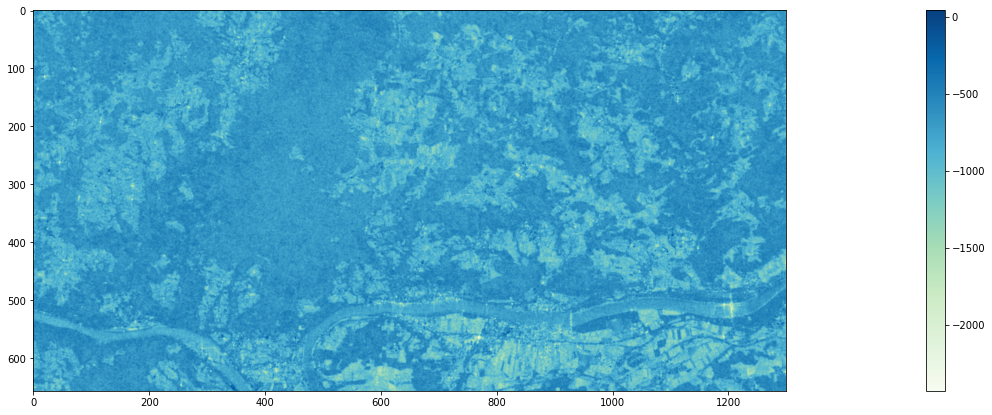

In [228]:
january = output_data.result[0].values
plt.figure(figsize=(50,7))
month = january
plt.subplot(1,1,1)
plt.imshow(month, cmap = "GnBu")   
plt.colorbar()